In [1]:
# import modules
#!pip install ipynb
import os
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from lightgbm import LGBMClassifier
from collections import Counter
import time
import pickle
import warnings
warnings.filterwarnings('ignore')
# custom-made utility modules
import ipynb.fs.full.config as c
import ipynb.fs.full.plotting as plotting



# MAIN FUNCTIONS

The code for this modelling assignment is modular. At this stage we define the main functions that will be used to perform the task. At a later stage we break down the task in defined sub-tasks where each function is called to execute one action. 

In [2]:
#### LOAD DATA
def load_data(path):
    '''

    Parameters
    ----------
    path : Class
        Used to create the path to the raw data.

    Returns
    -------
    train_files : Pandas dataframe
    test_files : Pandas dataframe

    '''
    path_to_data = path.to_data_raw()
    # list the csv files in the firectory
    csv_files = list(filter(lambda x: '.csv' in x, os.listdir(path_to_data)))
    
    train_files = pd.read_csv(c.join(path_to_data, csv_files[1]))
    test_files = pd.read_csv(c.join(path_to_data, csv_files[0]))
    
    return train_files, test_files     

#### EXPLORATORY DATA ANALYSIS
def perform_eda(df, dataset_type):
    
    '''
    Exploratory data analysis. 
        1. Check for missing values and log the features that contain them 
        and their type. 
        2. Visualize the missing values in a heatmap. 
        3. 
        
    Parameters
    ----------
    df : Pandas dataframe
        Contains the data of interest.
    dataset_type : STRING
        Corresponds to the type of dataset (raw, preprocessed, etc.).

    Returns
    -------
    None.

    '''

    
    # Check for missing values
    if df.isnull().sum().any():
        # Define the image path
        path_to_images = c.FetchPaths(c.PROJECTS_PATH, c.PROJECT_NAME).to_images()
        # plot the heatmap of the missing values
        plotting.visualize_missing_data(df, dataset_type, path_to_images)
        # Get the features that contain missing values
        features_with_missing_vals = df.isnull().any()[df.isnull().any()].index.tolist()
                        
        c.logging.critical('!!! There are features with missing values')
        c.logging.info(f'Features: {features_with_missing_vals}')
        c.logging.info(f'Types: {df.dtypes[features_with_missing_vals]}')
        
    else:
        c.logging.info('None of the features has missing values.')
    

    # Define the image path
    path_to_images = c.FetchPaths(c.PROJECTS_PATH, c.PROJECT_NAME).to_images()


    # plot and save the target distribution
    plotting.plot_target_distribution(df, dataset_type, path_to_images)
    # plot the feature correlation matrix
    plotting.plot_feature_correlation(df, dataset_type, path_to_images)
    

    
#### DATA PREPROCESSING
def preprocess_data(df, dataset_type, path):

    '''
    This script preprocesses the data and does: 
    
    1. Nan Imputation for the numerical and categorical values (median & mode)
    2. Frequency encoding for the categorical values    

    Parameters
    ----------
    df : Pandas dataframe
        Contains the data of interest.
    dataset_type : STRING
        Corresponds to the type of dataset (raw, preprocessed, etc.).

    Returns
    -------
    None.

    '''

    
    # Numerical features that contain missing values
    num_features = ['AGE','YOJ','CAR_AGE']            
    # fill the missing values with the median
    for feature in num_features:
        df[feature][df[feature].isnull()] = df[feature].median()
  
    ###########################
    # ENCODE CATEGORICAL VALUES   
    ############################
    # Categorical features that contain missing data
    cat_features_with_nans = ['INCOME', 'HOME_VAL', 'JOB']
    
    # fill the categorical values with the mode
    # filling with most common class
    df[cat_features_with_nans] = \
        df[cat_features_with_nans].apply(lambda x: x.fillna(x.value_counts().index[0]))

    # now select all categorical features and apply frequency encoding
    cat_features = df.select_dtypes(include=['object']).columns.tolist()
    for cat_feature in cat_features:
        # apply frequency encoding to the categorical feature(s)
        encoding_value = df.groupby(cat_feature).mean()['AGE']
        df[cat_feature] = df[cat_feature].map(encoding_value.to_dict())
    
    
    
    # finally, drop the TARGET_AMT feature
    df.drop(columns='TARGET_AMT', inplace=True)
    
    # Save the dataset in the preprocessed folder
    path_to_data = path.to_data_preprocessed()
    df.to_csv(c.join(path_to_data, f'{dataset_type}_preprocessed.csv'))
    
    if dataset_type=='train':
        ############################
        # PREPARE DATA FOR SKLEARN # 
        ############################
        y = df.TARGET_FLAG
        # drop the target
        df.drop(columns='TARGET_FLAG', inplace=True)
        X = df

        return X, y
    else:
        return None
        

def over_sample_dataset(X,y):
    '''
    The EDA revieled that the target distribution was skewed, which might
    lead to overfitting, to avoid that, we over-sample the missing target class.

    Parameters
    ----------
    X : Pandas dataframe
        The original feature matrix.
    y : Array
        The original target array.

    Returns
    -------
    X_over : Pandas dataframe
        The over-sampled feature matrix.
    y_over : Array
        The over-sampled target array.

    '''

    print('Original dataset shape %s' % Counter(y))
    col = X.columns.values
    sm = SMOTE(random_state=c.random_state)
    X_df, y_df = sm.fit_resample(X, y)
    print('Resampled dataset shape %s' % Counter(y_df))
    
    X_over = pd.DataFrame(X_df , columns=col)
    y_over = pd.DataFrame(y_df)

    # return the oversampled dataset
    return X_over, y_over
 

def split_data_for_classification(X,y, ratio=0.25):
    '''
    Split the original dataset using a simple train-test split    

    Parameters
    ----------
    X : Pandas dataframe
        The over-sampled feature matrix.
    y : Array
        The over-sampled target array.
    ratio: Float
        The ratio of the test set. Defaults to 25%

    Returns
    -------
    75% of the data to be used for training and 25% for testing

    '''    
    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size=ratio, 
                                                        stratify=y_over, 
                                                        random_state=c.random_state) 
    return X_train, X_test, y_train, y_test


def cross_val_hyperparam_tuning(RUN_RANDOMSEARCH, X,y, path):
    '''
    Perform Randomized search on hyper parameters. 

    Parameters
    ----------
    RUN_RANDOMSEARCH : Bool
        Whether to run the randomized search or load previous best params.
    X : DF
        Feature Matrix.
    y : Array
        Target.
    path : Class
        Used to save the best params if RUN_RANDOMSEARCH=False.

    Returns
    -------
    best_params : Dict
        Contains the best parameters of the Randomized search on hyper parameters.
        If RUN_RANDOMSEARCH == True, the function returns params calculated online, 
        otherwise, it loads them from a previous search. 

    '''

    path_to_params = path.to_params()    

    if RUN_RANDOMSEARCH:
    
        start_time = time.time()
        gkf = StratifiedKFold(n_splits=5, shuffle=True,
                              random_state=c.random_state).split(X=X, y=y)
        rsearch = RandomizedSearchCV(lgb_estimator, 
                                     param_distributions=c.param_test,
                                     cv=gkf, n_jobs=-1)
        lgb_model_random = rsearch.fit(X=X, y=np.ravel(y,order='C'))
        
        best_params = lgb_model_random.best_params_
        best_params["objective"] = "binary"
        
        print(lgb_model_random.best_params_, lgb_model_random.best_score_)
        print("--- %s seconds ---" % (time.time() - start_time))
        # save the parameters
        with open(c.join(path_to_params,'best_params.pkl'), 'wb') as f:
            pickle.dump(lgb_model_random.best_params_, f)
        
        best_params = lgb_model_random.best_params_ 
    else:

        with open(c.join(path_to_params,'best_params.pkl'), 'rb') as f:
            best_params = pickle.load(f)

        
    
    return best_params


def train_and_evaluate_model(classifier,X_train,y_train,X_test,y_test,
                         best_params, path):
    '''
    Receives the classifier and evaluates the model on the train_files.
    Plots the ROC AUC for this dataset.

    Returns
    -------
    None.

    '''
    clf = LGBMClassifier(**best_params)
    
    clf.fit(X_train, np.ravel(y_train,order='C'), eval_metric="auc")
    preds_proba_test = clf.predict_proba(X_test)
        
    # plot the AUC curve
    path_to_images = c.FetchPaths(c.PROJECTS_PATH, c.PROJECT_NAME).to_images()
    plotting.plot_roc_auc(y_test,preds_proba_test[:, 1], path_to_images)
    # save the classification report    
    
    

# PERFORM INFERENCE

The inference task is divided in the following parts. 

1. Load the raw data provided by the assignment.
2. Perform exploratory data analysis on the two assignments to build insights on the nature and the peculiarities of the data.
3. Preprocess the data (both datasets). 
4. Define the classifier
5. Optimize the classifier using hyper-parameter tuning. 
6. Use the "train_files" to train and evaluate the performance of the classifier. 
7. Finally, use the optimized classifier to generalize to the instances of the "test_files"

## GLOBALS

In [3]:
# set to false in order to not relaunch the RandomSearch and
# use the best hyperparameters that already calculated
RUN_RANDOMSEARCH = True
    
# call the path constructor - Defined @config.ipynb this constructor can be used to create the path derivatives
path = c.FetchPaths(c.PROJECTS_PATH, c.PROJECT_NAME)

## LOAD THE RAW DATA

In [4]:
# load the raw dataset
train_files, test_files  = load_data(path)

We will build a model based on the train_files and then infer the labels on the test_files.

## EXPLORATORY DATA ANALYSIS

This part contains the following steps: 
   
   1. <span style='color:blue '>[ARE THERE MISSING VALUES?] </span> To answer this, we plot a heatmap that allows us to observe the missing value per feature for both datasets.
   We observe that both datasets contain features with missing values, but none of the features has the majority of the values missing, to justify the exclusion of this feature. We will therefore proceed with data imputation. This is not the case of the feature "TARGET_AMT", which is empty in the "test_files" but not in the "train_files". We don't have any additionall information on this feature. We therefore drop this from both datasets ("train" and "test"). Additionally, this part of the code logs the features that contain missing values, as well as their type.<br><br>
   
   2. <span style='color:blue '> [HOW ARE THE TARGET LABELS DISTRIBUTED?] </span> To answer this, we plot the distribution of the labels for the target. We observed that, the distribution is skewed. There are way more "1" elements compared to "0". This indicates that we cannot use metrics such as accuracy or F1, <span style='color:green '> and we should rather use AUC or log-loss. </span> <br><br>
   
   3. <span style='color:blue '> [ARE THERE HIGH CORRELATED FEATURES?] </span> To answer this, we plot the correlation plot of the features (Spearman correlation). We do not observe any highly correlated features. We will therefore proceed <span style='color:green '> without applying any dimentionality reduction technique. </span> <br><br>
    

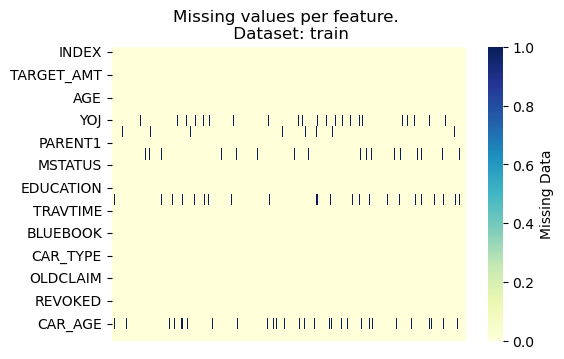

<Figure size 2000x1000 with 0 Axes>

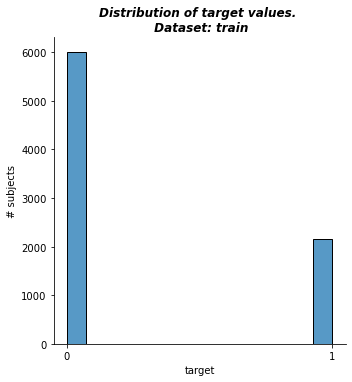

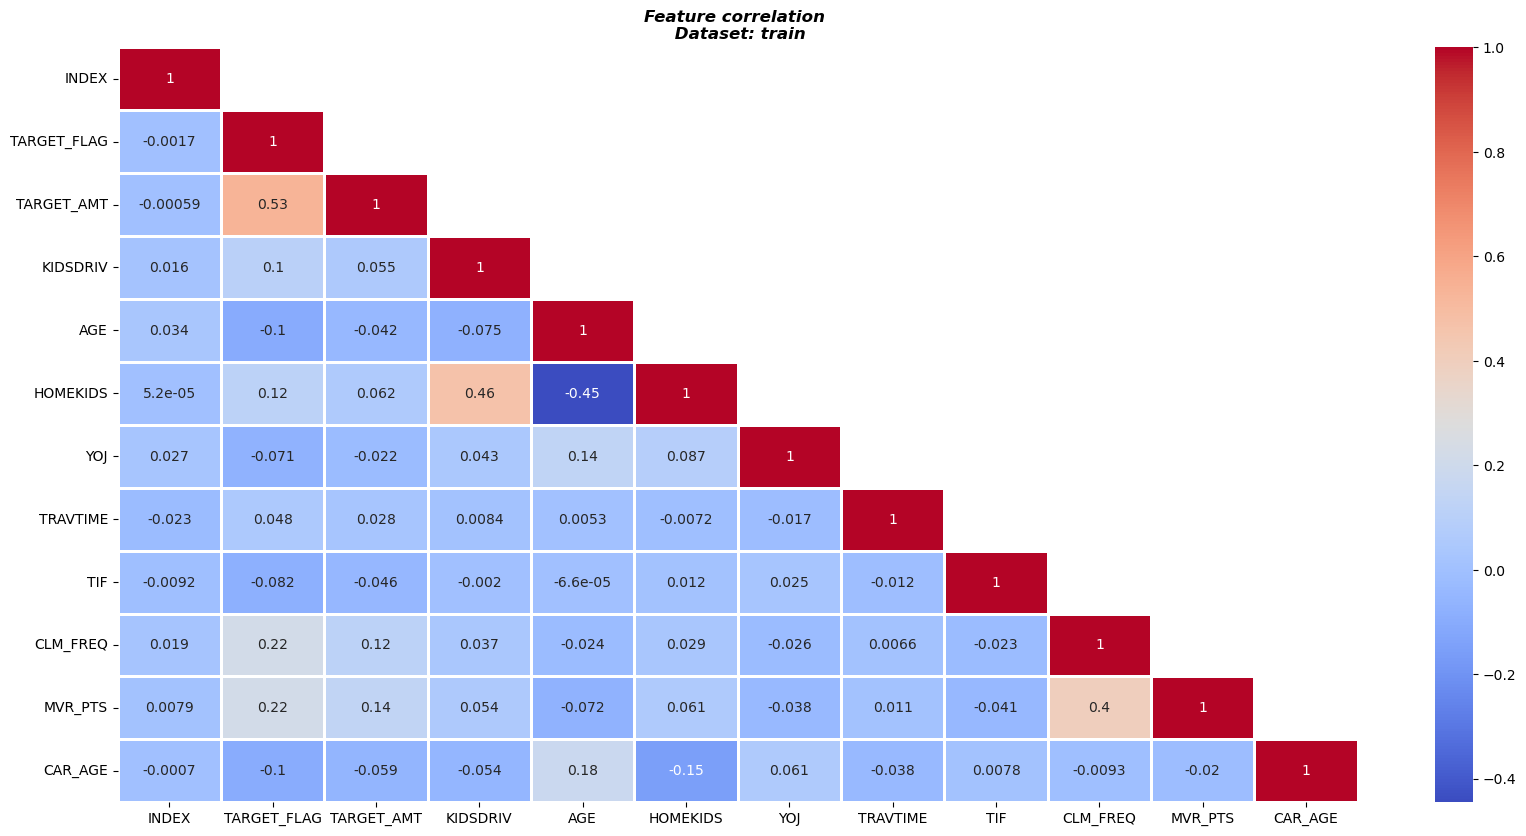

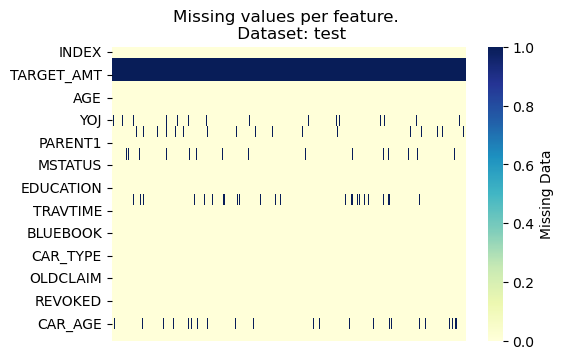

<Figure size 2000x1000 with 0 Axes>

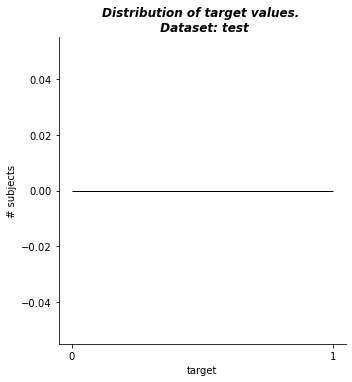

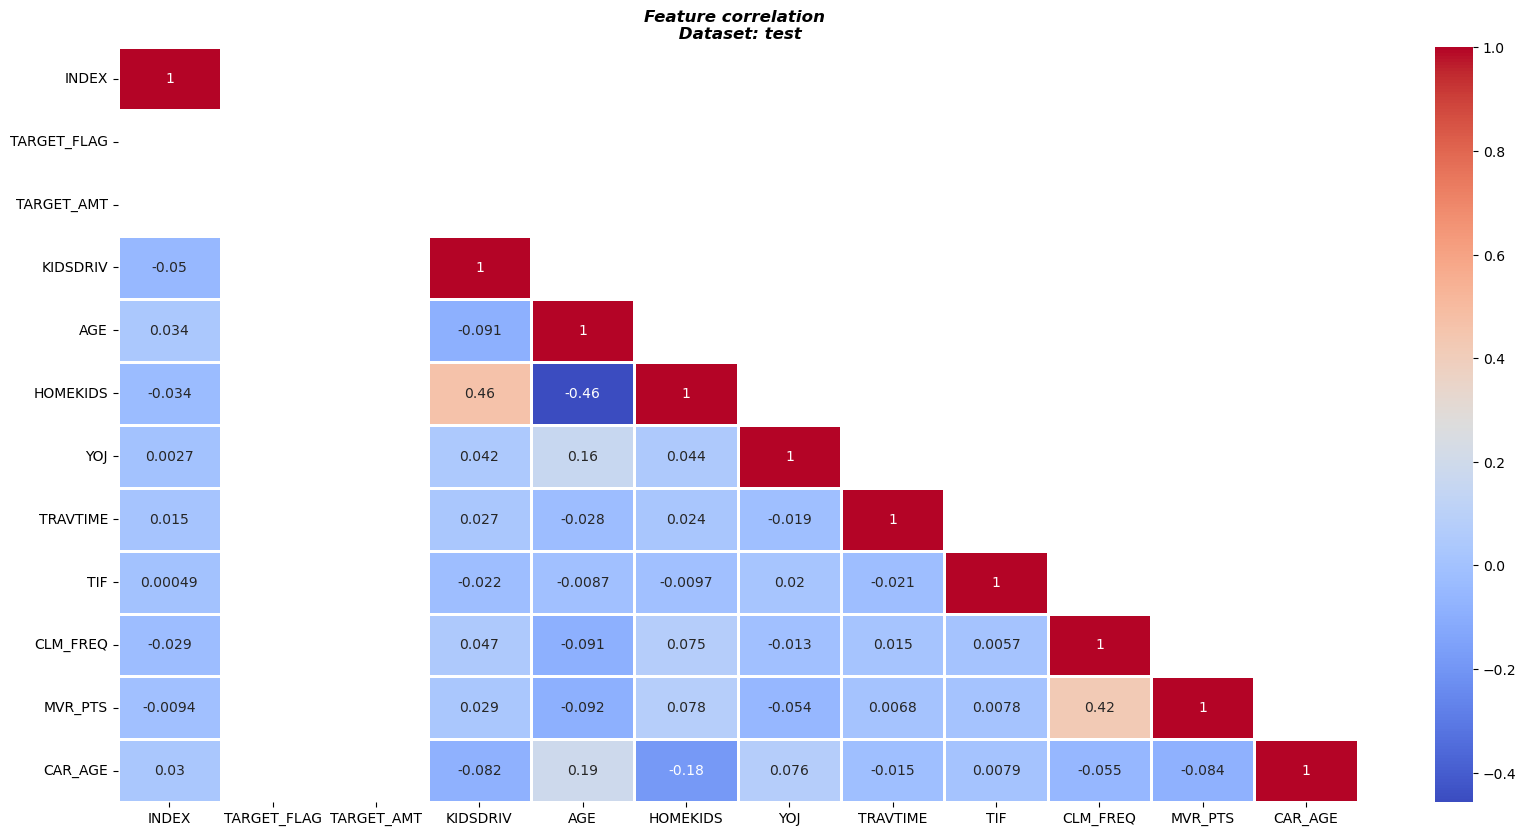

In [5]:
perform_eda(train_files, 'train')
perform_eda(test_files, 'test') 

## PREPROCESSING

Based on the observations of the EDA, we decided on the following preprocessing steps: 

1. <span style='color:red '>[DATA IMPUTATION] </span> The numerical missing values where set to their respective median, whereas for the categorical values, we used the mode. <br><br>
2. <span style='color:red '>[FREQUENCY ENCODING] </span> After imputing the missing values, we transformed the categorical features into numerical by applying frequency encoding. The preprocessed data (up to this stage) were stored into a separate directory. <br><br>
3. <span style='color:red '>[OVERSAMPLING] </span> To balance the target of the "train" dataset we also performed oversampling of the minority class, and used this dataset to tune our model. The alternative to that would have been a stratified K-fold, but this will take significantly more time to complete. 


In [6]:
# PREPROCESSING
# We will use the train dataset to build a model
X, y = preprocess_data(train_files, 'train', path)
# we perform preprocessing and save the data that will be used for the inference
preprocess_data(test_files, 'test', path)
# ovesample due to the target imbalance
X_over, y_over = over_sample_dataset(X,y)

Original dataset shape Counter({0: 6008, 1: 2153})
Resampled dataset shape Counter({0: 6008, 1: 6008})


## CLASSIFICATION USING LightGBM

For our task, we use the Light Gradient Boosting Machine, which is a fast and efficient implementation of a gradient boosting algorithm, currently, the state-of-the-art in classification problems. The light implementation of this model allows us to directly implement it in our framework, thus bypassing the exploration with simple linear models (such as SVM).

In [7]:
# split data to classify
X_train, X_test, y_train, y_test = split_data_for_classification(X_over,y_over, ratio=0.25)

# CLASSIFICATION USING LightGBM
lgb_estimator = LGBMClassifier(
    boosting_type="gbdt", objective="binary", learning_rate=0.01, metric="auc"
    )


## RANDOMIZED SEARCH ON HYPER PARAMETERS

To optimize for execution time, we used a randomized search for hyper-parameter tuning and not a grid-search.

In [8]:
# Hyperparameter search with Cross Validation
best_params = cross_val_hyperparam_tuning(RUN_RANDOMSEARCH,
                                          X_train,y_train, path)



{'colsample_bytree': 0.9876510034928003, 'min_child_samples': 165, 'min_child_weight': 0.01, 'num_leaves': 12, 'reg_alpha': 1, 'reg_lambda': 0.1, 'subsample': 0.4341999100788361, 'objective': 'binary'} 0.8186865151988023
--- 3.305881977081299 seconds ---


## TRAIN & EVALUATE THE MODEL ON THE "TRAIN FILES"

The performance of the model was evaluated on the "train_files". The model achieved high performance (AUC = 0.93). We are thus confident that we can use this model for generalization to new instances.

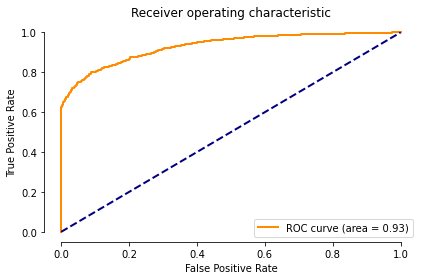

In [9]:
# TRAIN AND EVALUATE THE CLASSIFIER ON THE TRAIN FILES
train_and_evaluate_model(lgb_estimator,X_train,y_train,X_test,y_test,
                         best_params, path)

## USE THE OPTIMIZED MODEL TO PREDICT THE CLASS OF THE "TEST FILES"

Lastly, the tuned model was trained again using the whole "train_files" dataset and generated predictions for the target of the "test_files".

In [10]:
# Now, train a classifier on the whole dataset to predict the classes on 
# the test dataset
clf = LGBMClassifier(**best_params)
clf.fit(X, y)
X_of_interest = test_files.drop(columns = 'TARGET_FLAG')
y_predicted = clf.predict(X_of_interest)

# save the predicted classes in the predictions folder
np.savetxt(c.join(path.to_results(),'predicted_classes.csv'), 
           y_predicted, delimiter=",")